In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# %load_ext line_profiler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Setup the models that we will test

In [2]:
from lotka_volterra_model import LotkaVolterraModel
from dimerization_model import DimerizationModel
from gene_toggle_model import GeneToggleModel
from fast_slow_model import FastSlowModel
from goutsias_model import GoutsiasModel

from model_data import ModelData
        
all_model_data = []
initial_distributions = []
max_r_for_all_models = []
r_steps = []

# ########################
# # Lokta-Volterra model
# ########################
all_model_data.append(ModelData(LotkaVolterraModel(),
                                ['A', 'B'],
                                0.2,
                                'Lotka-Volterra'))
initial_distributions.append({(300, 100): 1.})
max_r_for_all_models.append(250)
r_steps.append(10)

# ########################
# # Dimerization model
# ########################
all_model_data.append(ModelData(DimerizationModel(),
                                ['mRNA', 'protein', 'dimer'],
                                0.05,
                                'Dimerization'))
initial_distributions.append({(10, 10, 0): 1.})
max_r_for_all_models.append(150)
r_steps.append(10)

########################
# Fast/slow model
########################
all_model_data.append(ModelData(FastSlowModel(),
                                ['A', 'B', 'C'],
                                4.,
                                'Fast/Slow'))
initial_distributions.append({(100, 100, 0): 1.})
max_r_for_all_models.append(150)
r_steps.append(10)

# #######################
# Goutsias model
# #######################
all_model_data.append(ModelData(GoutsiasModel(),
                                ['M', 'DNA', 'RNA', 'D', 'DNA.D', 'DNA.2D'],
                                0.2,
                                'Goutsias'))
initial_distributions.append({(20, 20, 20, 20, 20, 20): 1.})
max_r_for_all_models.append(20)
r_steps.append(1)

# Generate the plots comparing the support sizes to the probability lost

Lotka-Volterra
1
support size: 4, prob lost: 0.999999999999993
11
support size: 199, prob lost: 0.9999999999900663
21
support size: 694, prob lost: 0.9999999869064639
31
support size: 1489, prob lost: 0.9999992047266993
41
support size: 2584, prob lost: 0.9999805599147896
51
support size: 3979, prob lost: 0.9997500708508483
61
support size: 5674, prob lost: 0.9980652628344114
71
support size: 7669, prob lost: 0.9900543370113141
81
support size: 9964, prob lost: 0.9634279946758348
91
support size: 12559, prob lost: 0.8983505027672757
101
support size: 15453, prob lost: 0.7776271280481423
111
support size: 18558, prob lost: 0.6044750165824202
121
support size: 21813, prob lost: 0.41018618785221445
131
support size: 25218, prob lost: 0.2380643584439415
141
support size: 28773, prob lost: 0.11666421695718936
151
support size: 32478, prob lost: 0.04794397511275434
161
support size: 36333, prob lost: 0.01647987046213387
171
support size: 40338, prob lost: 0.004739260474648609
181
support siz

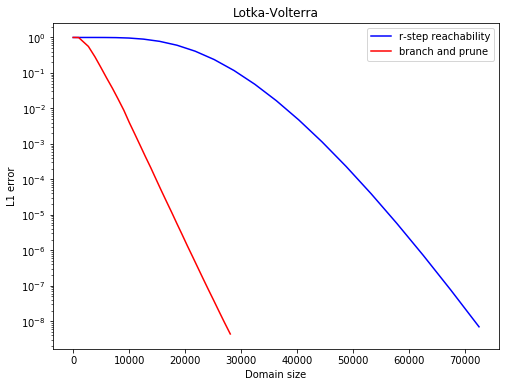

Dimerization
1
support size: 6, prob lost: 0.9999999999999994
11
support size: 935, prob lost: 0.9999999999106802
21
support size: 3247, prob lost: 0.9999959775462772
31
support size: 6894, prob lost: 0.997621466648123
41
support size: 12341, prob lost: 0.9152818423696771
51
support size: 19922, prob lost: 0.5333047751107497
61
support size: 29969, prob lost: 0.14308460712157856
71
support size: 42816, prob lost: 0.0180822455585805
81
support size: 58797, prob lost: 0.0012496704993059991
91
support size: 78244, prob lost: 5.409696747022495e-05
101
support size: 101491, prob lost: 1.6206183478594436e-06
111
support size: 128872, prob lost: 3.6068712348104916e-08
121
support size: 160719, prob lost: 6.277365034847892e-10
131
support size: 197366, prob lost: 8.874145309779457e-12
141
support size: 239147, prob lost: 1.0489532838257524e-13
error target: 1.05e-13
eps: 2.50e-01, prob lost: 1.00e+00, support size: 1
eps: 6.25e-02, prob lost: 9.96e-01, support size: 55
eps: 1.56e-02, prob lost

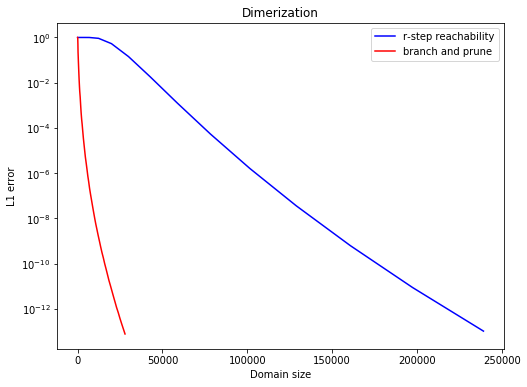

Fast/Slow
1
support size: 4, prob lost: 0.999999999999995
11
support size: 144, prob lost: 1.000000000000025
21
support size: 484, prob lost: 0.9999999999929176
31
support size: 1024, prob lost: 0.9999981473653717
41
support size: 1764, prob lost: 0.9990596234773614
51
support size: 2704, prob lost: 0.961193627762397
61
support size: 3844, prob lost: 0.6989597048038385
71
support size: 5184, prob lost: 0.25771890977506096
81
support size: 6724, prob lost: 0.03849153996370662
91
support size: 8464, prob lost: 0.002218208791466208
101
support size: 10301, prob lost: 4.997504629643767e-05
111
support size: 11276, prob lost: 4.4965536698920143e-07
121
support size: 12201, prob lost: 1.637743159896974e-09
131
support size: 13076, prob lost: 2.421390879429289e-12
141
support size: 13901, prob lost: 1.443015017191806e-15
error target: 1.44e-15
eps: 2.50e-01, prob lost: 1.00e+00, support size: 1
eps: 6.25e-02, prob lost: 1.00e+00, support size: 3
eps: 1.56e-02, prob lost: 1.00e+00, support siz

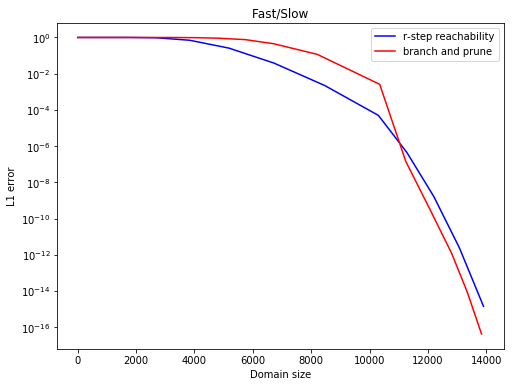

Goutsias
1
support size: 11, prob lost: 0.9847241260485442
2
support size: 61, prob lost: 0.8508333190547304
3
support size: 231, prob lost: 0.591275639133042
4
support size: 681, prob lost: 0.3341993724181048
5
support size: 1683, prob lost: 0.1578654123553088
6
support size: 3653, prob lost: 0.06370126230022939
7
support size: 7183, prob lost: 0.022320290373198482
8
support size: 13073, prob lost: 0.006874621268171719
9
support size: 22363, prob lost: 0.0018786258284688739
10
support size: 36365, prob lost: 0.0004589198237469326
11
support size: 56693, prob lost: 0.00010087347922015181
12
support size: 85286, prob lost: 2.0072559830451907e-05
13
support size: 124423, prob lost: 3.637336470140213e-06
14
support size: 176735, prob lost: 6.037722151493657e-07
15
support size: 245216, prob lost: 9.234747541153963e-08
16
support size: 333233, prob lost: 1.3091110975312421e-08
17
support size: 444537, prob lost: 1.7298497339431814e-09
18
support size: 583274, prob lost: 2.142312387470975e-

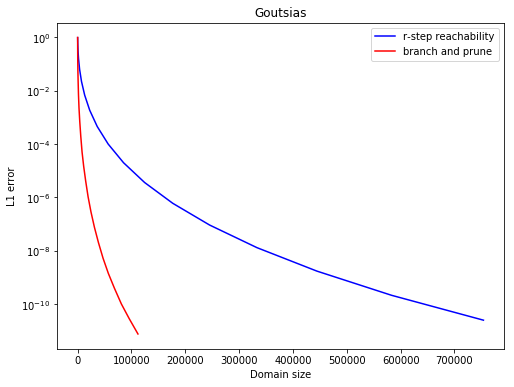

In [3]:
import r_step_reachability
import branch_and_prune
import gorde

from get_generator import get_generator
from scipy.sparse.linalg import expm_multiply

for model_data, init_dist, max_r, r_step in zip(all_model_data, initial_distributions, max_r_for_all_models, r_steps):
    print(model_data.model_name)
    r_values = range(1, max_r, r_step)
    r_step_support_size = np.zeros(len(r_values), dtype=np.int)
    r_step_prob_lost = np.zeros(len(r_values), dtype=np.float)
    
    ############
    # r-step
    ############
    for i,r in enumerate(r_values):
        print(r)
        support = r_step_reachability.get_support(model_data, init_dist, r)
        generator, initial_dist, index_to_state = get_generator(model_data, init_dist, support)
        res_dist = expm_multiply(generator * model_data.t, initial_dist)
        
        r_step_support_size[i] = len(support)
        r_step_prob_lost[i] = res_dist[0]
        print('support size: {}, prob lost: {}'.format(len(support), res_dist[0]))
    
    ############
    # branch--and--prune
    ############
    branch_prune_support_size = []
    branch_prune_prob_lost = []
    
    eps = 1.
    prob_lost = np.inf
    print('error target: {:.2e}'.format(r_step_prob_lost[-1]))
    while prob_lost > r_step_prob_lost[-1]:
        support, generator, initial_dist = branch_and_prune.get_support(model_data, init_dist, eps)
        res_dist = expm_multiply(generator.T * model_data.t, initial_dist)
        branch_prune_support_size.append(len(support))
        branch_prune_prob_lost.append(res_dist[0])
        
        eps /= 4.
        prob_lost = res_dist[0]
        print('eps: {:.2e}, prob lost: {:.2e}, support size: {}'.format(eps, prob_lost, len(support)))
        
    plt.plot(r_step_support_size, r_step_prob_lost, color='blue', label='r-step reachability')
    plt.plot(branch_prune_support_size, branch_prune_prob_lost, color='red', label='branch and prune')
    plt.legend()
    plt.yscale('log') #base 10
    plt.ylabel('L1 error')
    plt.xlabel('Domain size')
    plt.title(model_data.model_name)
    
    plt.gcf().set_size_inches(8, 6)
    plt.savefig('{}_domain_scaling.eps'.format(model_data.model_name.replace('/', '')),
            format='eps',
            bbox_inches='tight')
    
    plt.show()